# Durations
Este cuaderno consiste en un nuevo preprocesamiento adicional especializado para las fechas. Se completan algunos valores nulos faltantes y se termina de parsear y convertir los formatos de las fechas de los campos para terminar de homogenizar el formato.

In [1]:
import pandas as pd
import numpy as np

In [2]:
PATH = "/kaggle/input/rossmann-preprocessing/"
joined_train = pd.read_feather(PATH+'joined_train_before_durations.fth')
joined_test = pd.read_feather(PATH+'joined_test_before_durations.fth')

# Paso StateHoliday a booleana

In [3]:
joined_train['StateHoliday'].value_counts()

StateHoliday
0    986159
a     20260
b      6690
c      4100
Name: count, dtype: int64

In [4]:
joined_train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,CloudCover,Events,WindDirDegrees,StateName,Year_y,Week_y,CompetitionDaysOpen,CompetitionMonthsOpen,Promo2Days,Promo2Weeks
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,1.0,Fog,13,Hessen,2015,31,2510,24,9342,25
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,...,4.0,Fog,309,Thueringen,2015,31,2815,24,1950,25
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,...,2.0,Fog,354,NordrheinWestfalen,2015,31,3150,24,1579,25
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,...,6.0,Sunny,282,Berlin,2015,31,2145,24,9342,25
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,...,4.0,Sunny,290,Sachsen,2015,31,107,3,9342,25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,2013,...,6.0,Rain,215,NordrheinWestfalen,2013,1,0,0,0,0
1017205,1112,2,2013-01-01,0,0,0,0,a,1,2013,...,6.0,Rain,215,NordrheinWestfalen,2013,1,2453,24,8401,25
1017206,1113,2,2013-01-01,0,0,0,0,a,1,2013,...,6.0,Rain,251,SchleswigHolstein,2013,1,8387,24,8401,25
1017207,1114,2,2013-01-01,0,0,0,0,a,1,2013,...,6.0,Rain,234,Hamburg,2013,1,8387,24,8401,25


a = public holiday, b = Easter holiday, c = Christmas, 0 = None

In [5]:
joined_train['StateHoliday_bool'] = joined_train.StateHoliday!='0'
joined_test['StateHoliday_bool'] = joined_test.StateHoliday!='0'

## Durations

### Agrega columnas con "antes" y "despues" de eventos
Información adicional acerca de cuántos días antes o después de un evento específico ocurrió algo.

In [6]:
columns = ["Date", "Store", "Promo", "StateHoliday_bool", "SchoolHoliday"]

In [7]:
class elapsed(object):
    def __init__(self, fld):
        self.fld = fld
        self.last = pd.to_datetime(np.nan)
        self.last_store = 0
        
    def get(self, row):
        if row.Store != self.last_store:
            self.last = pd.to_datetime(np.nan)
            self.last_store = row.Store
        if (row[self.fld]): self.last = row.Date
        return row.Date-self.last

In [8]:
df_train = joined_train[columns]
df_test = joined_test[columns]

In [9]:
df_train.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday
0,2015-07-31,1,1,False,1
1,2015-07-31,2,1,False,1
2,2015-07-31,3,1,False,1
3,2015-07-31,4,1,False,1
4,2015-07-31,5,1,False,1


In [10]:
df_test.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday
0,2015-09-17,1,1,False,0
1,2015-09-17,3,1,False,0
2,2015-09-17,7,1,False,0
3,2015-09-17,8,1,False,0
4,2015-09-17,9,1,False,0


In [11]:
def add_elapsed(df, fld, prefix):
    sh_el = elapsed(fld)
    df[prefix+fld] = df.apply(sh_el.get, axis=1)

In [12]:
fld = 'SchoolHoliday'
df_train = df_train.sort_values(['Store', 'Date'])
add_elapsed(df_train, fld, 'After')
df_train.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday
1016095,2013-01-01,1,0,True,1,0 days
1014980,2013-01-02,1,0,False,1,0 days
1013865,2013-01-03,1,0,False,1,0 days
1012750,2013-01-04,1,0,False,1,0 days
1011635,2013-01-05,1,0,False,1,0 days


In [13]:
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(df_test, fld, 'After')
df_test.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday
40232,2015-08-01,1,0,False,1,0 days
39376,2015-08-02,1,0,False,1,0 days
38520,2015-08-03,1,1,False,1,0 days
37664,2015-08-04,1,1,False,1,0 days
36808,2015-08-05,1,1,False,1,0 days


In [14]:
df_train = df_train.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_train, fld, 'Before')
df_train.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday
0,2015-07-31,1,1,False,1,0 days,0 days
1115,2015-07-30,1,1,False,1,0 days,0 days
2230,2015-07-29,1,1,False,1,0 days,0 days
3345,2015-07-28,1,1,False,1,0 days,0 days
4460,2015-07-27,1,1,False,1,0 days,0 days


In [15]:
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_test, fld, 'Before')
df_test.head()

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday
0,2015-09-17,1,1,False,0,13 days,NaT
856,2015-09-16,1,1,False,0,12 days,NaT
1712,2015-09-15,1,1,False,0,11 days,NaT
2568,2015-09-14,1,1,False,0,10 days,NaT
3424,2015-09-13,1,0,False,0,9 days,NaT


In [16]:
fld = 'StateHoliday_bool'
df_train = df_train.sort_values(['Store', 'Date'])
add_elapsed(df_train, fld, 'After')
df_train = df_train.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_train, fld, 'Before')

In [17]:
fld = 'StateHoliday_bool'
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(df_test, fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_test, fld, 'Before')

In [18]:
fld = 'Promo'
df_train = df_train.sort_values(['Store', 'Date'])
add_elapsed(df_train, fld, 'After')
df_train = df_train.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_train, fld, 'Before')

In [19]:
fld = 'Promo'
df_test = df_test.sort_values(['Store', 'Date'])
add_elapsed(df_test, fld, 'After')
df_test = df_test.sort_values(['Store', 'Date'], ascending=[True, False])
add_elapsed(df_test, fld, 'Before')

In [20]:
df_train.head(10)

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
0,2015-07-31,1,1,False,1,0 days,0 days,57 days,NaT,0 days,0 days
1115,2015-07-30,1,1,False,1,0 days,0 days,56 days,NaT,0 days,0 days
2230,2015-07-29,1,1,False,1,0 days,0 days,55 days,NaT,0 days,0 days
3345,2015-07-28,1,1,False,1,0 days,0 days,54 days,NaT,0 days,0 days
4460,2015-07-27,1,1,False,1,0 days,0 days,53 days,NaT,0 days,0 days
5575,2015-07-26,1,0,False,0,107 days,-1 days,52 days,NaT,9 days,-1 days
6690,2015-07-25,1,0,False,0,106 days,-2 days,51 days,NaT,8 days,-2 days
7805,2015-07-24,1,0,False,0,105 days,-3 days,50 days,NaT,7 days,-3 days
8920,2015-07-23,1,0,False,0,104 days,-4 days,49 days,NaT,6 days,-4 days
10035,2015-07-22,1,0,False,0,103 days,-5 days,48 days,NaT,5 days,-5 days


In [21]:
df_train = df_train.set_index("Date")
df_test = df_test.set_index("Date")

In [22]:
df_train.sort_values('Date').head(5)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2013-01-01,1115,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days
2013-01-01,746,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days
2013-01-01,171,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days
2013-01-01,694,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days
2013-01-01,396,0,True,1,0 days,0 days,0 days,0 days,NaT,-6 days


NaT: Not a Time

In [23]:
df_test.sort_values('Date').head(5)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2015-08-01,553,0,False,0,NaT,-2 days,NaT,NaT,NaT,-2 days
2015-08-01,394,0,False,1,0 days,0 days,NaT,NaT,NaT,-2 days
2015-08-01,393,0,False,0,NaT,-2 days,NaT,NaT,NaT,-2 days
2015-08-01,392,0,False,0,NaT,-2 days,NaT,NaT,NaT,-2 days
2015-08-01,391,0,False,0,NaT,-2 days,NaT,NaT,NaT,-2 days


### Elimina los NaT

In [24]:
columns = ['SchoolHoliday', 'StateHoliday_bool', 'Promo']

In [25]:
for o in ['Before', 'After']:
    for p in columns:
        a = o+p
        df_train[a] = df_train[a].fillna(pd.Timedelta(0)).dt.days
        df_test[a] = df_test[a].fillna(pd.Timedelta(0)).dt.days

In [26]:
df_train.sort_values('Date').head(10)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2013-01-01,1115,0,True,1,0,0,0,0,0,-6
2013-01-01,746,0,True,1,0,0,0,0,0,-6
2013-01-01,171,0,True,1,0,0,0,0,0,-6
2013-01-01,694,0,True,1,0,0,0,0,0,-6
2013-01-01,396,0,True,1,0,0,0,0,0,-6
2013-01-01,196,0,True,1,0,0,0,0,0,-6
2013-01-01,271,0,True,1,0,0,0,0,0,-6
2013-01-01,32,0,True,1,0,0,0,0,0,-6
2013-01-01,440,0,True,1,0,0,0,0,0,-6


In [27]:
df_test.sort_values('Date').head(10)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2015-08-01,553,0,False,0,0,-2,0,0,0,-2
2015-08-01,394,0,False,1,0,0,0,0,0,-2
2015-08-01,393,0,False,0,0,-2,0,0,0,-2
2015-08-01,392,0,False,0,0,-2,0,0,0,-2
2015-08-01,391,0,False,0,0,-2,0,0,0,-2
2015-08-01,389,0,False,0,0,-2,0,0,0,-2
2015-08-01,388,0,False,0,0,-2,0,0,0,-2
2015-08-01,387,0,False,0,0,-2,0,0,0,-2
2015-08-01,386,0,False,0,0,-2,0,0,0,-2


In [28]:
from matplotlib import pyplot as plt

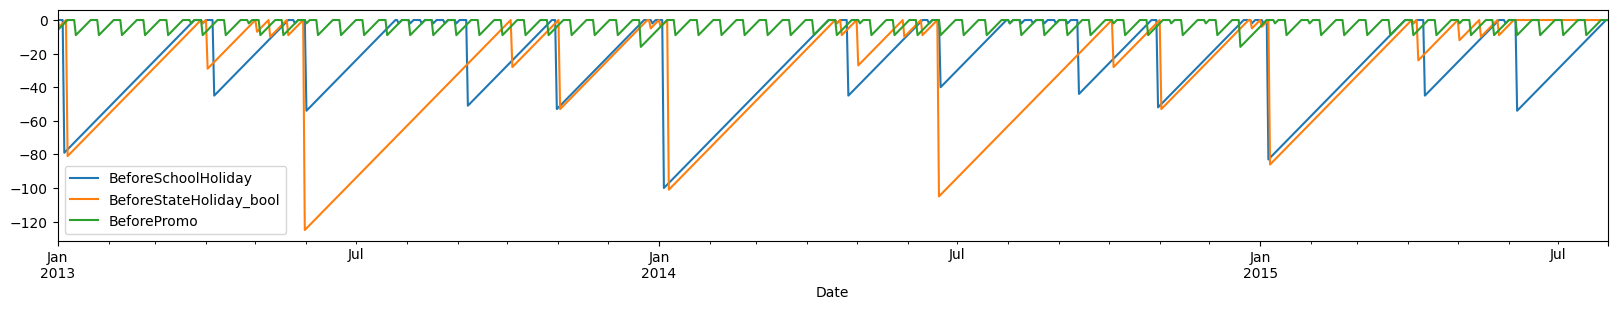

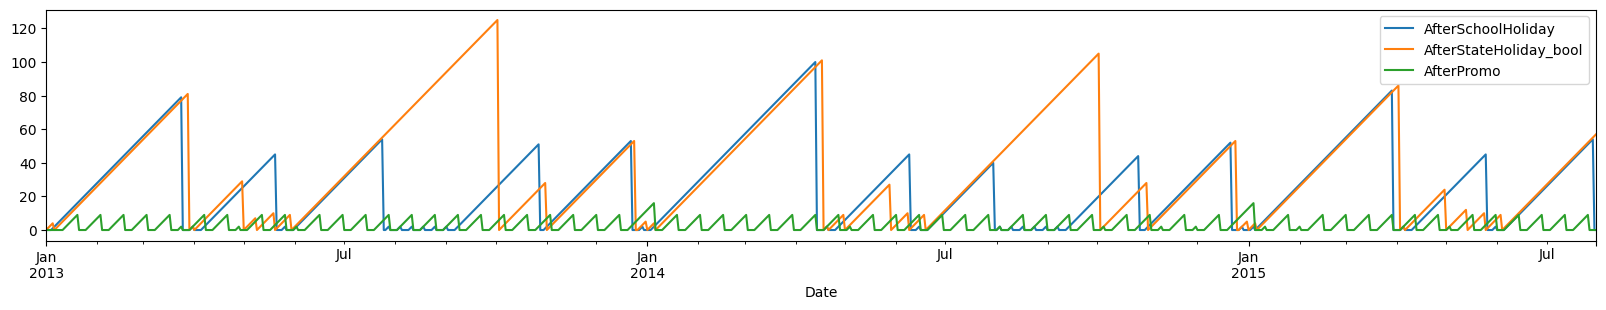

In [29]:
plt.figure(figsize=(20,3))
df_train[df_train['Store'] == 280]['BeforeSchoolHoliday'].plot()
df_train[df_train['Store'] == 280]['BeforeStateHoliday_bool'].plot()
df_train[df_train['Store'] == 280]['BeforePromo'].plot()
plt.legend()
plt.show()

plt.figure(figsize=(20,3))
df_train[df_train['Store'] == 280]['AfterSchoolHoliday'].plot()
df_train[df_train['Store'] == 280]['AfterStateHoliday_bool'].plot()
df_train[df_train['Store'] == 280]['AfterPromo'].plot()
plt.legend()
plt.show()

### "Suavizado" de columnas temporales 

In [30]:
# Datos del store 1 ordenados por fecha
df_train[df_train[['Store']+columns]['Store'] == 1].sort_values('Date').head(20)

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2013-01-01,1,0,True,1,0,0,0,0,0,-6
2013-01-02,1,0,False,1,0,0,1,-86,0,-5
2013-01-03,1,0,False,1,0,0,2,-85,0,-4
2013-01-04,1,0,False,1,0,0,3,-84,0,-3
2013-01-05,1,0,False,1,0,0,4,-83,0,-2
2013-01-06,1,0,False,1,0,0,5,-82,0,-1
2013-01-07,1,1,False,1,0,0,6,-81,0,0
2013-01-08,1,1,False,1,0,0,7,-80,0,0
2013-01-09,1,1,False,1,0,0,8,-79,0,0


In [31]:
bwd_train = df_train[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
bwd_test = df_test[['Store']+columns].sort_index().groupby("Store").rolling(7, min_periods=1).sum()
bwd_train.head(20)

SchoolHoliday  StateHoliday_bool  Promo
Store Date                                               
1     2013-01-01            1.0                1.0    0.0
      2013-01-02            2.0                1.0    0.0
      2013-01-03            3.0                1.0    0.0
      2013-01-04            4.0                1.0    0.0
      2013-01-05            5.0                1.0    0.0
      2013-01-06            6.0                1.0    0.0
      2013-01-07            7.0                1.0    1.0
      2013-01-08            7.0                0.0    2.0
      2013-01-09            7.0                0.0    3.0
      2013-01-10            7.0                0.0    4.0
      2013-01-11            7.0                0.0    5.0
      2013-01-12            6.0                0.0    5.0
      2013-01-13            5.0                0.0    5.0
      2013-01-14            4.0                0.0    4.0
      2013-01-15            3.0                0.0    3.0
      2013-01-16            2.0                0.0    2.0
      2013-01-17            1.0                0.0    1.0
      2013-01-18            0.0                0.0    0.0
      2013-01-19            0.0                0.0    0.0
      2013-01-20            0.0                0.0    0.0

In [32]:
bwd_train

SchoolHoliday  StateHoliday_bool  Promo
Store Date                                               
1     2013-01-01            1.0                1.0    0.0
      2013-01-02            2.0                1.0    0.0
      2013-01-03            3.0                1.0    0.0
      2013-01-04            4.0                1.0    0.0
      2013-01-05            5.0                1.0    0.0
...                         ...                ...    ...
1115  2015-07-27            1.0                0.0    1.0
      2015-07-28            2.0                0.0    2.0
      2015-07-29            3.0                0.0    3.0
      2015-07-30            4.0                0.0    4.0
      2015-07-31            5.0                0.0    5.0

[1017209 rows x 3 columns]

In [33]:
df_train

,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
Date,,,,,,,,,,
2015-07-31,1,1,False,1,0,0,57,0,0,0
2015-07-30,1,1,False,1,0,0,56,0,0,0
2015-07-29,1,1,False,1,0,0,55,0,0,0
2015-07-28,1,1,False,1,0,0,54,0,0,0
2015-07-27,1,1,False,1,0,0,53,0,0,0
...,...,...,...,...,...,...,...,...,...,...
2013-01-05,1115,0,False,1,0,0,4,-83,0,-2
2013-01-04,1115,0,False,1,0,0,3,-84,0,-3
2013-01-03,1115,0,False,1,0,0,2,-85,0,-4


In [34]:
bwd_train.reset_index(inplace=True)
#bwd_train.drop('Store',axis = 1,inplace=True)
bwd_test.reset_index(inplace=True)
#bwd_test.drop('Store',axis = 1,inplace=True)

In [35]:
bwd_train.head(20)

,Store,Date,SchoolHoliday,StateHoliday_bool,Promo
0,1,2013-01-01,1.0,1.0,0.0
1,1,2013-01-02,2.0,1.0,0.0
2,1,2013-01-03,3.0,1.0,0.0
3,1,2013-01-04,4.0,1.0,0.0
4,1,2013-01-05,5.0,1.0,0.0
5,1,2013-01-06,6.0,1.0,0.0
6,1,2013-01-07,7.0,1.0,1.0
7,1,2013-01-08,7.0,0.0,2.0
8,1,2013-01-09,7.0,0.0,3.0
9,1,2013-01-10,7.0,0.0,4.0


In [36]:
# Ordena al reves
fwd_train = df_train[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()
fwd_test = df_test[['Store']+columns].sort_index(ascending=False).groupby("Store").rolling(7, min_periods=1).sum()

In [37]:
fwd_train.head(20)

SchoolHoliday  StateHoliday_bool  Promo
Store Date                                               
1     2015-07-31            1.0                0.0    1.0
      2015-07-30            2.0                0.0    2.0
      2015-07-29            3.0                0.0    3.0
      2015-07-28            4.0                0.0    4.0
      2015-07-27            5.0                0.0    5.0
      2015-07-26            5.0                0.0    5.0
      2015-07-25            5.0                0.0    5.0
      2015-07-24            4.0                0.0    4.0
      2015-07-23            3.0                0.0    3.0
      2015-07-22            2.0                0.0    2.0
      2015-07-21            1.0                0.0    1.0
      2015-07-20            0.0                0.0    0.0
      2015-07-19            0.0                0.0    0.0
      2015-07-18            0.0                0.0    0.0
      2015-07-17            0.0                0.0    1.0
      2015-07-16            0.0                0.0    2.0
      2015-07-15            0.0                0.0    3.0
      2015-07-14            0.0                0.0    4.0
      2015-07-13            0.0                0.0    5.0
      2015-07-12            0.0                0.0    5.0

In [38]:
fwd_train.reset_index(inplace=True)
#fwd_train.drop('Store',axis=1,inplace=True)
fwd_test.reset_index(inplace=True)
#fwd_test.drop('Store',axis = 1,inplace=True)

In [39]:
df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)

In [40]:
df_train

,Date,Store,Promo,StateHoliday_bool,SchoolHoliday,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo
0,2015-07-31,1,1,False,1,0,0,57,0,0,0
1,2015-07-30,1,1,False,1,0,0,56,0,0,0
2,2015-07-29,1,1,False,1,0,0,55,0,0,0
3,2015-07-28,1,1,False,1,0,0,54,0,0,0
4,2015-07-27,1,1,False,1,0,0,53,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...
1017204,2013-01-05,1115,0,False,1,0,0,4,-83,0,-2
1017205,2013-01-04,1115,0,False,1,0,0,3,-84,0,-3
1017206,2013-01-03,1115,0,False,1,0,0,2,-85,0,-4
1017207,2013-01-02,1115,0,False,1,0,0,1,-86,0,-5


In [41]:
df_train = df_train.merge(bwd_train, 'left', left_on=['Date', 'Store'],right_on = ['Date','Store'], suffixes=['', '_bw'])
df_train = df_train.merge(fwd_train, 'left', left_on=['Date', 'Store'],right_on = ['Date','Store'], suffixes=['', '_fw'])
df_test = df_test.merge(bwd_test, 'left', left_on=['Date', 'Store'],right_on = ['Date','Store'], suffixes=['', '_bw'])
df_test = df_test.merge(fwd_test, 'left', left_on=['Date', 'Store'],right_on = ['Date','Store'], suffixes=['', '_fw'])

In [42]:
df_train.drop(columns,axis=1,inplace=True)
df_test.drop(columns,axis=1,inplace=True)

In [43]:
#df_train.drop(columns=["level_0", "level_1", "level_1_fw"], inplace = True)
#df_test.drop(columns=["level_0", "level_1", "level_1_fw"], inplace = True)

In [44]:
df_train.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw
0,2015-07-31,1,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2015-07-30,1,0,0,56,0,0,0,4.0,0.0,4.0,2.0,0.0,2.0
2,2015-07-29,1,0,0,55,0,0,0,3.0,0.0,3.0,3.0,0.0,3.0
3,2015-07-28,1,0,0,54,0,0,0,2.0,0.0,2.0,4.0,0.0,4.0
4,2015-07-27,1,0,0,53,0,0,0,1.0,0.0,1.0,5.0,0.0,5.0


In [45]:
df_train["Date"] = pd.to_datetime(df_train.Date)
df_test["Date"] = pd.to_datetime(df_test.Date)

In [46]:
df_train.head()

,Date,Store,AfterSchoolHoliday,BeforeSchoolHoliday,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw
0,2015-07-31,1,0,0,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2015-07-30,1,0,0,56,0,0,0,4.0,0.0,4.0,2.0,0.0,2.0
2,2015-07-29,1,0,0,55,0,0,0,3.0,0.0,3.0,3.0,0.0,3.0
3,2015-07-28,1,0,0,54,0,0,0,2.0,0.0,2.0,4.0,0.0,4.0
4,2015-07-27,1,0,0,53,0,0,0,1.0,0.0,1.0,5.0,0.0,5.0


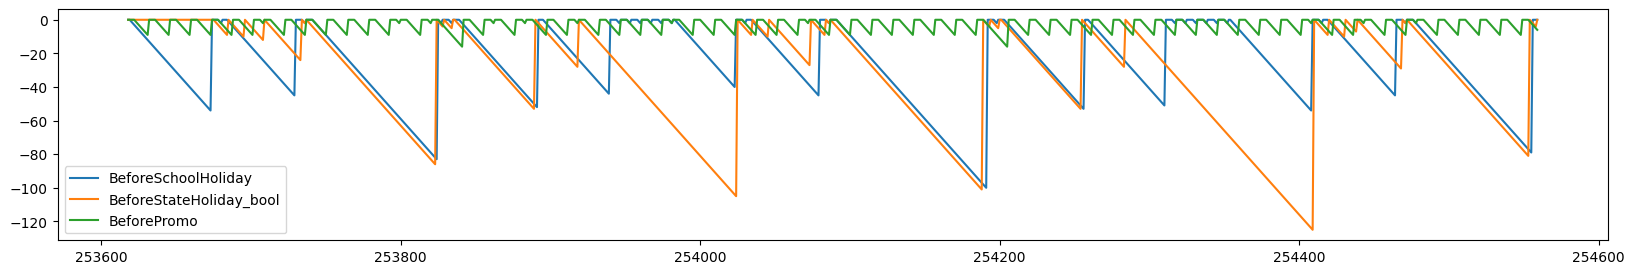

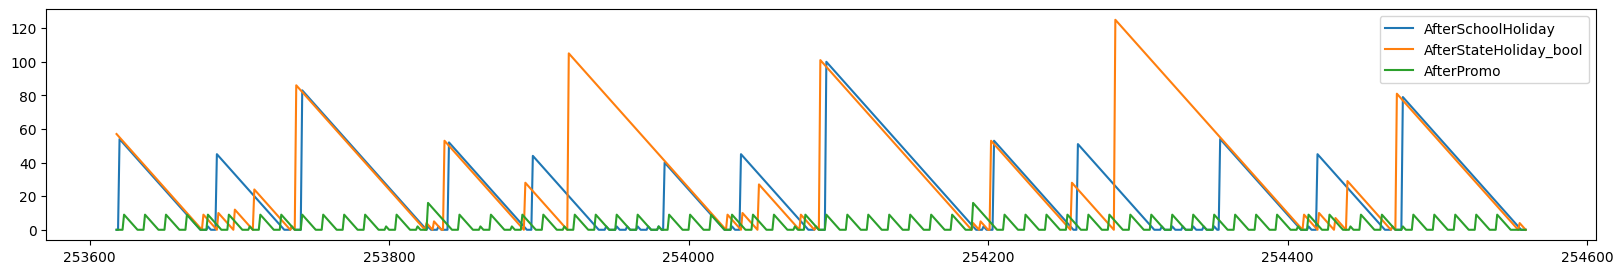

In [47]:
plt.figure(figsize=(20,3))
df_train[df_train['Store'] == 280]['BeforeSchoolHoliday'].plot()
df_train[df_train['Store'] == 280]['BeforeStateHoliday_bool'].plot()
df_train[df_train['Store'] == 280]['BeforePromo'].plot()
plt.legend()
plt.show()

plt.figure(figsize=(20,3))
df_train[df_train['Store'] == 280]['AfterSchoolHoliday'].plot()
df_train[df_train['Store'] == 280]['AfterStateHoliday_bool'].plot()
df_train[df_train['Store'] == 280]['AfterPromo'].plot()
plt.legend()
plt.show()

In [48]:
def join_df(left, right, left_on, right_on=None):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", "_y"))

In [49]:
joined_train = join_df(joined_train, df_train, ['Store', 'Date'])
joined_test = join_df(joined_test, df_test, ['Store', 'Date'])

In [50]:
joined_train.shape

(1017209, 81)

In [51]:
joined_train.to_feather('all_preprocessed_train.fth')

In [52]:
joined_test.to_feather('all_preprocessed_test.fth')

Text(0.5, 1.0, 'Promo')

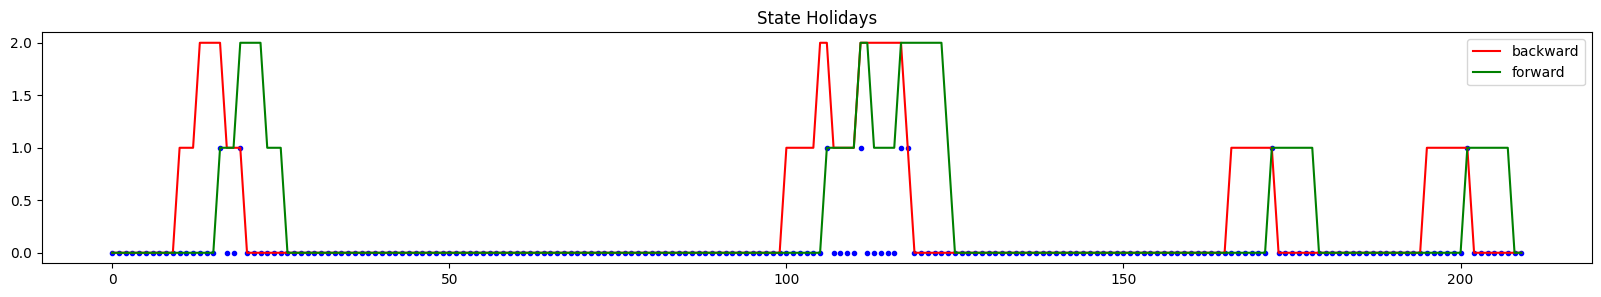

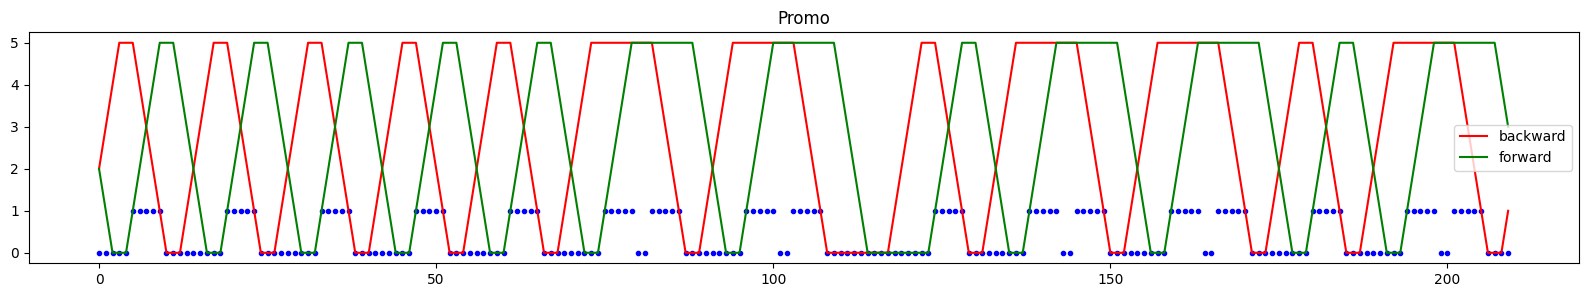

In [53]:
plt.figure(figsize=(20,3))
plt.plot(joined_train[joined_train['Store']==280]['StateHoliday_bool'].values[100:310]*1.0, c='b', marker='.', linestyle='None')
plt.plot(joined_train[joined_train['Store']==280]['StateHoliday_bool_bw'].values[100:310]*1.0, c='r', label='backward')
plt.plot(joined_train[joined_train['Store']==280]['StateHoliday_bool_fw'].values[100:310]*1.0, c='g', label='forward')
plt.legend()
plt.title('State Holidays')
plt.figure(figsize=(20,3))
plt.plot(joined_train[joined_train['Store']==280]['Promo'].values[100:310]*1.0, c='b', marker='.', linestyle='None')
plt.plot(joined_train[joined_train['Store']==280]['Promo_bw'].values[100:310]*1.0, c='r', label='backward')
plt.plot(joined_train[joined_train['Store']==280]['Promo_fw'].values[100:310]*1.0, c='g', label='forward')
plt.legend()
plt.title('Promo')

In [54]:
joined_train

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,Year,...,AfterStateHoliday_bool,BeforeStateHoliday_bool,AfterPromo,BeforePromo,SchoolHoliday_bw,StateHoliday_bool_bw,Promo_bw,SchoolHoliday_fw,StateHoliday_bool_fw,Promo_fw
0,1,5,2015-07-31,5263,555,1,1,0,1,2015,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
1,2,5,2015-07-31,6064,625,1,1,0,1,2015,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
2,3,5,2015-07-31,8314,821,1,1,0,1,2015,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
3,4,5,2015-07-31,13995,1498,1,1,0,1,2015,...,67,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
4,5,5,2015-07-31,4822,559,1,1,0,1,2015,...,57,0,0,0,5.0,0.0,5.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1017204,1111,2,2013-01-01,0,0,0,0,a,1,2013,...,0,0,0,-6,1.0,1.0,0.0,4.0,1.0,1.0
1017205,1112,2,2013-01-01,0,0,0,0,a,1,2013,...,0,0,0,-6,1.0,1.0,0.0,4.0,1.0,1.0
1017206,1113,2,2013-01-01,0,0,0,0,a,1,2013,...,0,0,0,-6,1.0,1.0,0.0,4.0,1.0,1.0
1017207,1114,2,2013-01-01,0,0,0,0,a,1,2013,...,0,0,0,-6,1.0,1.0,0.0,4.0,1.0,1.0
